## This notebook aims to re-calculate strand bias using the three methods described by [Guo2012](https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-13-666). This notebook starts from the three trimmed.sorted.bam files: 
- BC01.trimmed.sorted.bam
- BC02.trimmed.sorted.bam
- BC03.trimmed.sorted.bam

The first three commands below use "scripts/freqs_modified.py", which generate variants tables containing: 
- VariantCov
- ForwardVariantCov
- ReverseVariantCov
- RefCov
- ForwardRefCov
- ReverseRefCov

In [1]:
!python scripts/freqs_modified.py --snpfreqmin 0.03 bam/BC01.trimmed.sorted.bam refs/ZIKV_REF.fasta > BC01_modified.variants.0.03.txt
!python scripts/freqs_modified.py --snpfreqmin 0.03 bam/BC02.trimmed.sorted.bam refs/ZIKV_REF.fasta > BC02_modified.variants.0.03.txt
!python scripts/freqs_modified.py --snpfreqmin 0.03 bam/BC03.trimmed.sorted.bam refs/ZIKV_REF.fasta > BC03_modified.variants.0.03.txt


The three commands below are trying to reproduce the generation of BC01/02/03.variants.0.03.txt from BC01/02/03.trimmed.sorted.bam using "scripts/freqs.py". BC01/02/03.trimmed.sorted.bam and scripts/freqs.py were taken from [Nicholas J. Loman](https://github.com/nickloman/zika-isnv/).  

In [2]:
!python scripts/freqs.py --snpfreqmin 0.03 bam/BC01.trimmed.sorted.bam refs/ZIKV_REF.fasta > BC01_confirm.variants.0.03.txt
!python scripts/freqs.py --snpfreqmin 0.03 bam/BC02.trimmed.sorted.bam refs/ZIKV_REF.fasta > BC02_confirm.variants.0.03.txt
!python scripts/freqs.py --snpfreqmin 0.03 bam/BC03.trimmed.sorted.bam refs/ZIKV_REF.fasta > BC03_confirm.variants.0.03.txt


#### Conclusion: BC01/02/03_modified.variants.0.03.txt and BC01/02/03_confirm.variants.0.03.txt are the same, except that BC01/02/03_modified.variants.0.03.txt contain three more columns—RefCov, ForwardRefCov, and ReverseRefCov. 
#### BC01/02/03_confirm.variants.0.03.txt (generated here) are different compared to BC01/02/03.variants.0.03.txt (from [Nicholas J. Loman](https://github.com/nickloman/zika-isnv/)), the commands and input files used are exactly the same though. BC01/02/03.trimmed.sorted.bam by [Nicholas J. Loman](https://github.com/nickloman/zika-isnv/) should be updated.  

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R 
library("tidyverse")
options(dplyr.width = Inf)
options(readr.num_columns = 0)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.2     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [5]:
%%R 
# Strand bias calculation, formula taken from Guo2012.  
SB_calc = function(ForwardRefCov, ForwardVariantCov, ReverseRefCov, ReverseVariantCov){
    a = ForwardRefCov
    b = ForwardVariantCov
    c = ReverseRefCov
    d = ReverseVariantCov
    bias = abs(b/(a+b) - d/(c+d)) / ((b+d)/(a+b+c+d))
    return (bias)
}

# GATK strand bias calculation, formula taken from Guo2012. 
GATK_SB_calc = function(ForwardRefCov, ForwardVariantCov, ReverseRefCov, ReverseVariantCov){
    a = ForwardRefCov
    b = ForwardVariantCov
    c = ReverseRefCov
    d = ReverseVariantCov
    bias1 = b/(a+b)*(c/(c+d))/((a+c)/(a+b+c+d))
    bias2 = d/(c+d)*(a/(a+b))/((a+c)/(a+b+c+d))
    return(pmax(bias1,bias2))
}

# Fisher strand bias calculation, formula taken from Guo2012. 
Fisher_SB_calc = function(ForwardRefCov, ForwardVariantCov, ReverseRefCov, ReverseVariantCov){
    a = ForwardRefCov
    b = ForwardVariantCov
    c = ReverseRefCov
    d = ReverseVariantCov
    testor = matrix(c(a,b,c,d), ncol=2)
    return (1 - fisher.test(testor)$p.value)
}


In [6]:
%%R
# Test the three strand calculation methods on Guo2012 Table 3 
# Filter out variants with ForwardRefCov <= 10 or ForwardVariantCov <= 10 or ReverseRefCov <= 10 or ReverseVariantCov <= 10. 
guo = read_tsv("Guo_table_3.txt")
guo %>%
  mutate(SB = SB_calc(ForwardRefCov, ForwardVariantCov, ReverseRefCov, ReverseVariantCov)) %>%
  mutate(GATK_SB = GATK_SB_calc(ForwardRefCov, ForwardVariantCov, ReverseRefCov, ReverseVariantCov)) %>% 
  rowwise() %>% 
  mutate(Fisher_SB = Fisher_SB_calc(ForwardRefCov, ForwardVariantCov, ReverseRefCov, ReverseVariantCov))


# A tibble: 3 x 8
# Rowwise: 
       Pos ForwardVariantCov ReverseVariantCov ForwardRefCov ReverseRefCov    SB
     <dbl>             <dbl>             <dbl>         <dbl>         <dbl> <dbl>
1 43917013                 2                 0            11            20  2.54
2 95923670                 2                 0            16            10  1.56
3 57088850                 2                 0             8            16  2.6 
  GATK_SB Fisher_SB
    <dbl>     <dbl>
1   0.164     0.852
2   0.120     0.476
3   0.217     0.862


SB, GATK_SB, and Fisher_SB are the same compared to those provided in table 3 in Guo2012. 

Next is to apply clustering models on the MinION data. 

In [7]:
%%R 
# Read in the three datasets "BC01.variants.0.03.txt", "BC02.variants.0.03.txt", "BC03.variants.0.03.txt". 
barcode1snps=read_tsv("BC01_modified.variants.0.03.txt")
barcode1snps$replica = 'a'

barcode2snps=read_tsv("BC02_modified.variants.0.03.txt")
barcode2snps$replica = 'b'

barcode3snps=read_tsv("BC03_modified.variants.0.03.txt")
barcode3snps$replica = 'c'

In [8]:
%%R
# Merge the three datasets
minion_variants=rbind(barcode1snps, barcode2snps, barcode3snps)

Remove position in amplicons with primer mismatches.

These positions are described in "expectedpositions.txt", where each of the position are labelled by: 
- "REMOVE": positions to be removed, because they are located in the amplicons with primer mismatches
- "TRUE": true positives variants by comparing the consensus nt sequence of the gb records KX087101 and KU955593. 
- "FALSE": false positives, variants detected by MinION, but not labelled as "TRUE". 

In [9]:
%%R 
expectedpositions=read_tsv("expectedpositions.txt")

In [10]:
%%R 
# Remove positions with the label "REMOVE"
minion_variants_positions=minion_variants %>%
   left_join(expectedpositions, by=c("Pos" = "Position")) %>%
   filter(State != 'Remove')

In [11]:
%%R
# Add strand bias info
# Note that here we do not filter out position 
# with (ForwardRefCov or ForwardVariantCov or ReverseRefCov or ReverseVariantCov < 10)
# Instead, we filter out rows with NaN in SB or GATK_SB or Fisher_SB. 

minion_variants_positions %>%
  mutate(Decision = ifelse(grepl("TRUE", State), 1, 0)) %>%
  mutate(SB = SB_calc(ForwardRefCov, ForwardVariantCov, ReverseRefCov, ReverseVariantCov)) %>%
  mutate(GATK_SB = GATK_SB_calc(ForwardRefCov, ForwardVariantCov, ReverseRefCov, ReverseVariantCov)) %>% 
  rowwise() %>% 
  mutate(Fisher_SB = Fisher_SB_calc(ForwardRefCov, ForwardVariantCov, ReverseRefCov, ReverseVariantCov)) %>% 
  filter(!is.na(SB)) %>%
  filter(!is.na(GATK_SB)) %>%
  filter(!is.na(Fisher_SB)) %>%
  write_tsv("minion_variants_positions_SB.tsv")

### Codes below are written by me in Python. These codes construct 
- a logistic regression classifier using ALT freq and strand bias, 
- a KNN classifier using ALT freq and strand bias, 
- a SVM classifier using ALT freq and strand bias. 

In [12]:
import numpy as np 
import pandas as pd 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import cycle

In [13]:
data = pd.read_csv("minion_variants_positions_SB.tsv", sep="\t")
data

,Pos,Qual,Freq,Ref,Base,UngappedCoverage,TotalCoverage,VariantCov,ForwardVariantCov,ReverseVariantCov,RefCov,ForwardRefCov,ReverseRefCov,replica,State,Decision,SB,GATK_SB,Fisher_SB
0,1070,0,0.091876,C,T,1034,1035,95,49,46,938,558,380,a,True,1,0.296377,0.109318,0.845000
1,1129,0,0.038532,G,A,545,548,21,19,2,522,134,388,a,False,0,3.078417,0.128516,1.000000
2,1175,0,0.247379,A,G,477,515,118,105,13,359,55,304,a,True,1,2.487032,0.836195,1.000000
3,1176,0,0.043544,G,A,666,668,29,29,0,637,178,459,a,False,0,3.217391,0.146475,1.000000
4,1183,0,0.031088,C,T,386,390,12,4,8,366,365,1,a,False,0,27.658537,0.908081,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,10342,0,0.030395,A,T,329,333,10,10,0,317,223,94,c,False,0,1.403433,0.044272,0.931737
431,10349,0,0.131959,T,C,485,487,64,36,28,419,152,267,c,True,1,0.728833,0.199787,0.996427
432,10360,0,0.059671,C,T,486,487,29,1,28,457,277,180,c,False,0,2.195685,0.142643,1.000000
433,10361,0,0.121348,T,C,445,465,54,26,28,391,249,142,c,True,1,0.578174,0.169730,0.964145


Wrap up the function—plot_KNN_LR_SVM_ROC—applying KNN, LogisticRegression, and SVM(linear) models, then draw ROC curves. The input data (a tab separated table) should contain at least three columns: 
- Decision: prior knowledge if a variant is true or false positive. If true -> Decision = 1. If false -> Decision = 0
- Freq: frequency of alternative allele 
- at least one of "SB", or "GATK_SB", or "Fisher_SB". It is okay to have all three biases. 

In [14]:
def plot_KNN_LR_SVM_ROC(data, which_bias="SB"): 
    alpha = np.logspace(-3, 5, 100)
    x = data[['Freq', which_bias]]
    y = data['Decision']
    Freq = data['Freq']
    SB = data[which_bias]
    colors = cycle('gmc')
    plt.figure(figsize=(7, 6), facecolor='w')
    models = [['KNN', KNeighborsClassifier(n_neighbors=5)],
              ['LogisticRegression', LogisticRegressionCV(Cs=alpha, penalty='l2', cv=5)],
              ['SVM(Linear)', GridSearchCV(SVC(kernel='linear', decision_function_shape='ovo'), param_grid={'C': alpha}, cv=5)]]
    for (name, model), color in zip(models, colors):
        model.fit(x, y)
        if hasattr(model, 'predict_proba'):
            y_score = model.predict_proba(x)[:,1]
        else:
            y_score = model.decision_function(x)
        fpr, tpr, thresholds = metrics.roc_curve(y, y_score)
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, c=color, lw=2, alpha=0.7, label="{0}, AUC={1:.3f}".format(name, auc))
    
    fpr, tpr, thresholds = metrics.roc_curve(y, Freq)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, c='b', lw=2, alpha=0.7, label="{0}, AUC={1:.3f}".format("Frequency", auc))
    
    fpr, tpr, thresholds = metrics.roc_curve(y, SB)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, c='y', lw=2, alpha=0.7, label="{0}, AUC={1:.3f}".format("Strand bias", auc))
    
    plt.plot((0, 1), (0, 1), c='#808080', lw=2, ls='--', alpha=0.7)
    plt.xlim((-0.01, 1.02))
    plt.ylim((-0.01, 1.02))
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.grid(b=True, ls=':')
    plt.legend(loc='lower right', fancybox=True, framealpha=0.8, edgecolor='#303030', fontsize=12)
    plt.title("ROC Frequency " + which_bias, fontsize=16)
    plt.savefig("ROC Frequency " + which_bias + ".pdf", format="pdf")

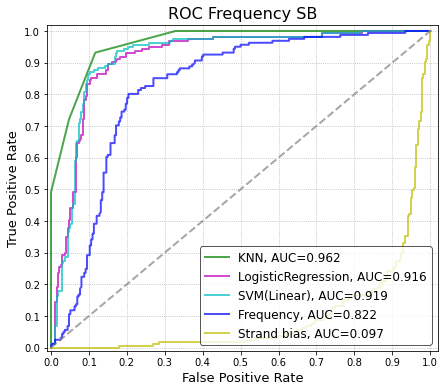

In [15]:
plot_KNN_LR_SVM_ROC(data, which_bias="SB")

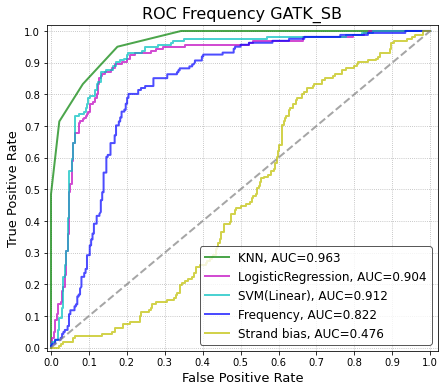

In [16]:
plot_KNN_LR_SVM_ROC(data, which_bias="GATK_SB")

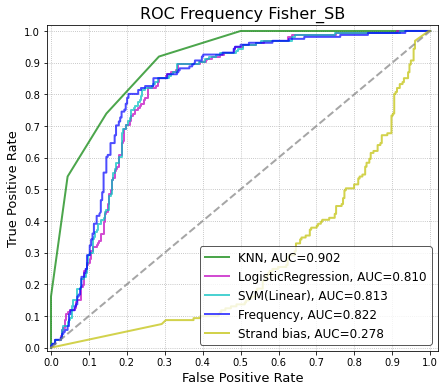

In [17]:
plot_KNN_LR_SVM_ROC(data, which_bias="Fisher_SB")

### [Conclusion] When strand bias—SB, or GATK_SB, or Fisher_SB—is used alone, it is not a good discriminator to discriminate true and false positives. 
However, when SB was combined with ALT frequency and fed into one of the models—KNN, logistic regression, and SVM(linear), a higher AUC was obtained. 

Same for GATK_SB, but not for Fisher_SB. 

Wrup up the function—plot_LR_clusters—plotting logistic regression clusters. 

In [18]:
def plot_LR_clusters(data, which_bias="SB"): 
    x = data[['Freq', which_bias]]
    y = data['Decision']
    
    alpha = np.logspace(-3, 5, 100)
    Logis_model = LogisticRegressionCV(Cs=alpha, penalty='l2', cv=5)
    Logis_model.fit(x, y)
    y_hat=Logis_model.predict(x)
    
    x_array=x.to_numpy()
    N, M = 500, 500 
    x1_min, x1_max = x_array[:, 0].min(), x_array[:, 0].max()
    x2_min, x2_max = x_array[:, 1].min(), x_array[:, 1].max()
    t1=np.linspace(x1_min,x1_max,N)
    t2=np.linspace(x2_min,x2_max,M)
    x1, x2 = np.meshgrid(t1,t2)
    x_test = np.stack((x1.flat, x2.flat), axis=1)
    y_test = Logis_model.predict(x_test)
    y_test = y_test.reshape(x1.shape) 
    
    cm_light = mpl.colors.ListedColormap(['#77E0A0', '#FF8080'])
    cm_dark = mpl.colors.ListedColormap(['g', 'r'])
    
    plt.figure(facecolor='w')
    plt.pcolormesh(x1, x2, y_test, cmap=cm_light)
    plt.scatter(x['Freq'], x[which_bias], c=y, edgecolors='k', s=50, cmap=cm_dark)
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel(which_bias, fontsize=14)
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.grid()
    patchs = [mpatches.Patch(color='#77E0A0', label='False positive'),
              mpatches.Patch(color='#FF8080', label='True positive')]
    plt.legend(handles=patchs, fancybox=True, framealpha=0.8)
    plt.title('Logistic regression classifier', fontsize=17)
    plt.show()
    print("Logistic regression classifier accuracy = {0:.3f}".format(100*accuracy_score(y, y_hat)))
    

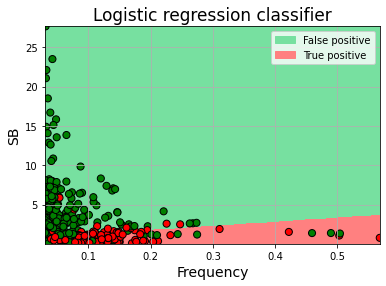

Logistic regression classifier accuracy = 87.586


In [19]:
plot_LR_clusters(data,'SB')

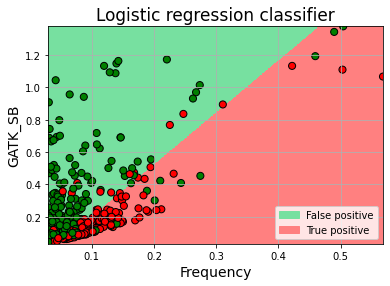

Logistic regression classifier accuracy = 84.138


In [20]:
plot_LR_clusters(data,'GATK_SB')

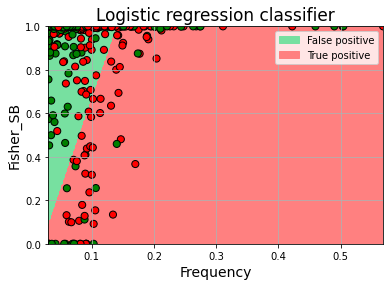

Logistic regression classifier accuracy = 69.655


In [21]:
plot_LR_clusters(data,'Fisher_SB')